In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
np.random.seed(42)

# Lecture 11B: Clustering Analysis in Python

- Section 401
- Nov 15, 2023

## Last lecture (11A)

- Introduction to clustering with scikit-learn
- K-means algorithm for non-spatial clustering

## Today

- Spatial clustering with the DBSCAN algorithm
- Exercise on spatial clustering of NYC taxi trips

## Part 2: Spatial clustering

Now on to the more traditional view of "clustering"...

## DBSCAN

"Density-Based Spatial Clustering of Applications with Noise"

- Clusters are areas of **high density** separated by areas of low density.
- Can identify clusters of any shape
- Good at separating **core samples** in high-density regions from low-density **noise** samples
- **Best for spatial data**

## Two key parameters 

1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
1. **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point (including the point itself).

### Example Scenario

<img width="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1200px-DBSCAN-Illustration.svg.png" alt="DBSCAN-Illustration.svg">


- `min_samples` = 4. 
- Point A and the other red points are **core points**
    - There are at least `min_samples` (4) points (including the point itself) within a distance of `eps` from each of these points.
    - These points are all reachable from one another, so they for a cluster
- Points B and C are **edge points** of the cluster
    - They are reachable (within a distance of `eps`) from the core points so they are part of the cluster 
    - They do not have at least `min_pts` within a distance of `eps` so they are not core points
- Point N is a **noise point** — it not within a distance of `eps` from any of the cluster points

## Importance of parameter choices

Higher `min_samples` or a lower `eps` requires a higher density necessary to form a cluster.

## Example: OpenStreetMap GPS traces in Philadelphia

- Data extracted from the set of 1 billion GPS traces from OSM.
- CRS is EPSG=3857 — `x` and `y` in units of meters

In [2]:
coords = gpd.read_file('./data/osm_gps_philadelphia.geojson')
coords.head() 

x          y                          geometry
0 -8370750.5  4865303.0  POINT (-8370750.500 4865303.000)
1 -8368298.0  4859096.5  POINT (-8368298.000 4859096.500)
2 -8365991.0  4860380.0  POINT (-8365991.000 4860380.000)
3 -8372306.5  4868231.0  POINT (-8372306.500 4868231.000)
4 -8376768.5  4864341.0  POINT (-8376768.500 4864341.000)

In [3]:
num_points = len(coords)

print(f"Total number of points = {num_points}")

Total number of points = 52358


## DBSCAN basics

In [4]:
from sklearn.cluster import dbscan 

In [5]:
dbscan?

Signature:
dbscan(
    X,
    eps=0.5,
    *,
    min_samples=5,
    metric='minkowski',
    metric_params=None,
    algorithm='auto',
    leaf_size=30,
    p=2,
    sample_weight=None,
    n_jobs=None,
)
Docstring:
Perform DBSCAN clustering from vector array or distance matrix.

Read more in the :ref:`User Guide <dbscan>`.

Parameters
----------
X : {array-like, sparse (CSR) matrix} of shape (n_samples, n_features) or             (n_samples, n_samples)
    A feature array, or array of distances between samples if
    ``metric='precomputed'``.

eps : float, default=0.5
    The maximum distance between two samples for one to be considered
    as in the neighborhood of the other. This is not a maximum bound
    on the distances of points within a cluster. This is the most
    important DBSCAN parameter to choose appropriately for your data set
    and distance function.

min_samples : int, default=5
    The number of samples (or total weight) in a neighborhood for a point
    to be consi

In [6]:
# some parameters to start with
eps = 100  # in meters
min_samples = 50

cores, labels = dbscan(coords[["x", "y"]], eps=eps, min_samples=min_samples)

The function returns two objects, which we call `cores` and `labels`. `cores` contains the indices of each point which is classified as a core. 

In [7]:
# The first 5 elements
cores[:5]

array([1, 2, 4, 6, 8])

The length of cores tells you how many core samples we have:

In [8]:
num_cores = len(cores)
print(f"Number of core samples = {num_cores}")

Number of core samples = 29655


The `labels` tells you the cluster number each point belongs to. Those points classified as noise receive a cluster number of `-1`: 

In [9]:
# The first 5 elements
labels[:5]

array([-1,  0,  0, -1,  1])

The `labels` array is the same length as our input data, so we can add it as a column in our original data frame

In [10]:
# Add our labels to the original data
coords['label'] = labels

In [11]:
coords.head()

x          y                          geometry  label
0 -8370750.5  4865303.0  POINT (-8370750.500 4865303.000)     -1
1 -8368298.0  4859096.5  POINT (-8368298.000 4859096.500)      0
2 -8365991.0  4860380.0  POINT (-8365991.000 4860380.000)      0
3 -8372306.5  4868231.0  POINT (-8372306.500 4868231.000)     -1
4 -8376768.5  4864341.0  POINT (-8376768.500 4864341.000)      1

The number of clusters is the number of unique labels minus one (because noise has a label of -1)

In [12]:
num_clusters = coords['label'].nunique() - 1
print(f"number of clusters = {num_clusters}")

number of clusters = 42


We can group by the `label` column to get the size of each cluster:

In [13]:
cluster_sizes = coords.groupby('label', as_index=False).size()

cluster_sizes

label   size
0      -1  19076
1       0  17763
2       1   4116
3       2    269
4       3   2094
5       4    131
6       5    127
7       6    116
8       7   2077
9       8    225
10      9   1051
11     10    260
12     11    765
13     12    131
14     13    110
15     14    300
16     15    137
17     16    591
18     17    387
19     18    274
20     19    154
21     20    294
22     21     71
23     22    154
24     23     74
25     24    106
26     25    135
27     26     86
28     27    277
29     28    134
30     29     90
31     30    102
32     31     57
33     32     51
34     33     83
35     34     50
36     35     50
37     36     78
38     37     53
39     38     68
40     39     50
41     40     91
42     41     50

In [14]:
# All points get assigned a cluster label (-1 reserved for noise)
cluster_sizes['size'].sum() == num_points

True

The number of noise points is the size of the cluster with label "-1":

In [15]:
num_noise = cluster_sizes.iloc[0]['size']

print(f"number of noise points = {num_noise}")

number of noise points = 19076


If points aren't noise or core samples, they must be edges:

In [16]:
num_edges = num_points - num_cores - num_noise
print(f"Number of edge points = {num_edges}")

Number of edge points = 3627


## Now let's plot the noise and clusters

- Extract each cluster: select points with the same label number
- Plot the cluster centers: the mean `x` and mean `y` value for each cluster

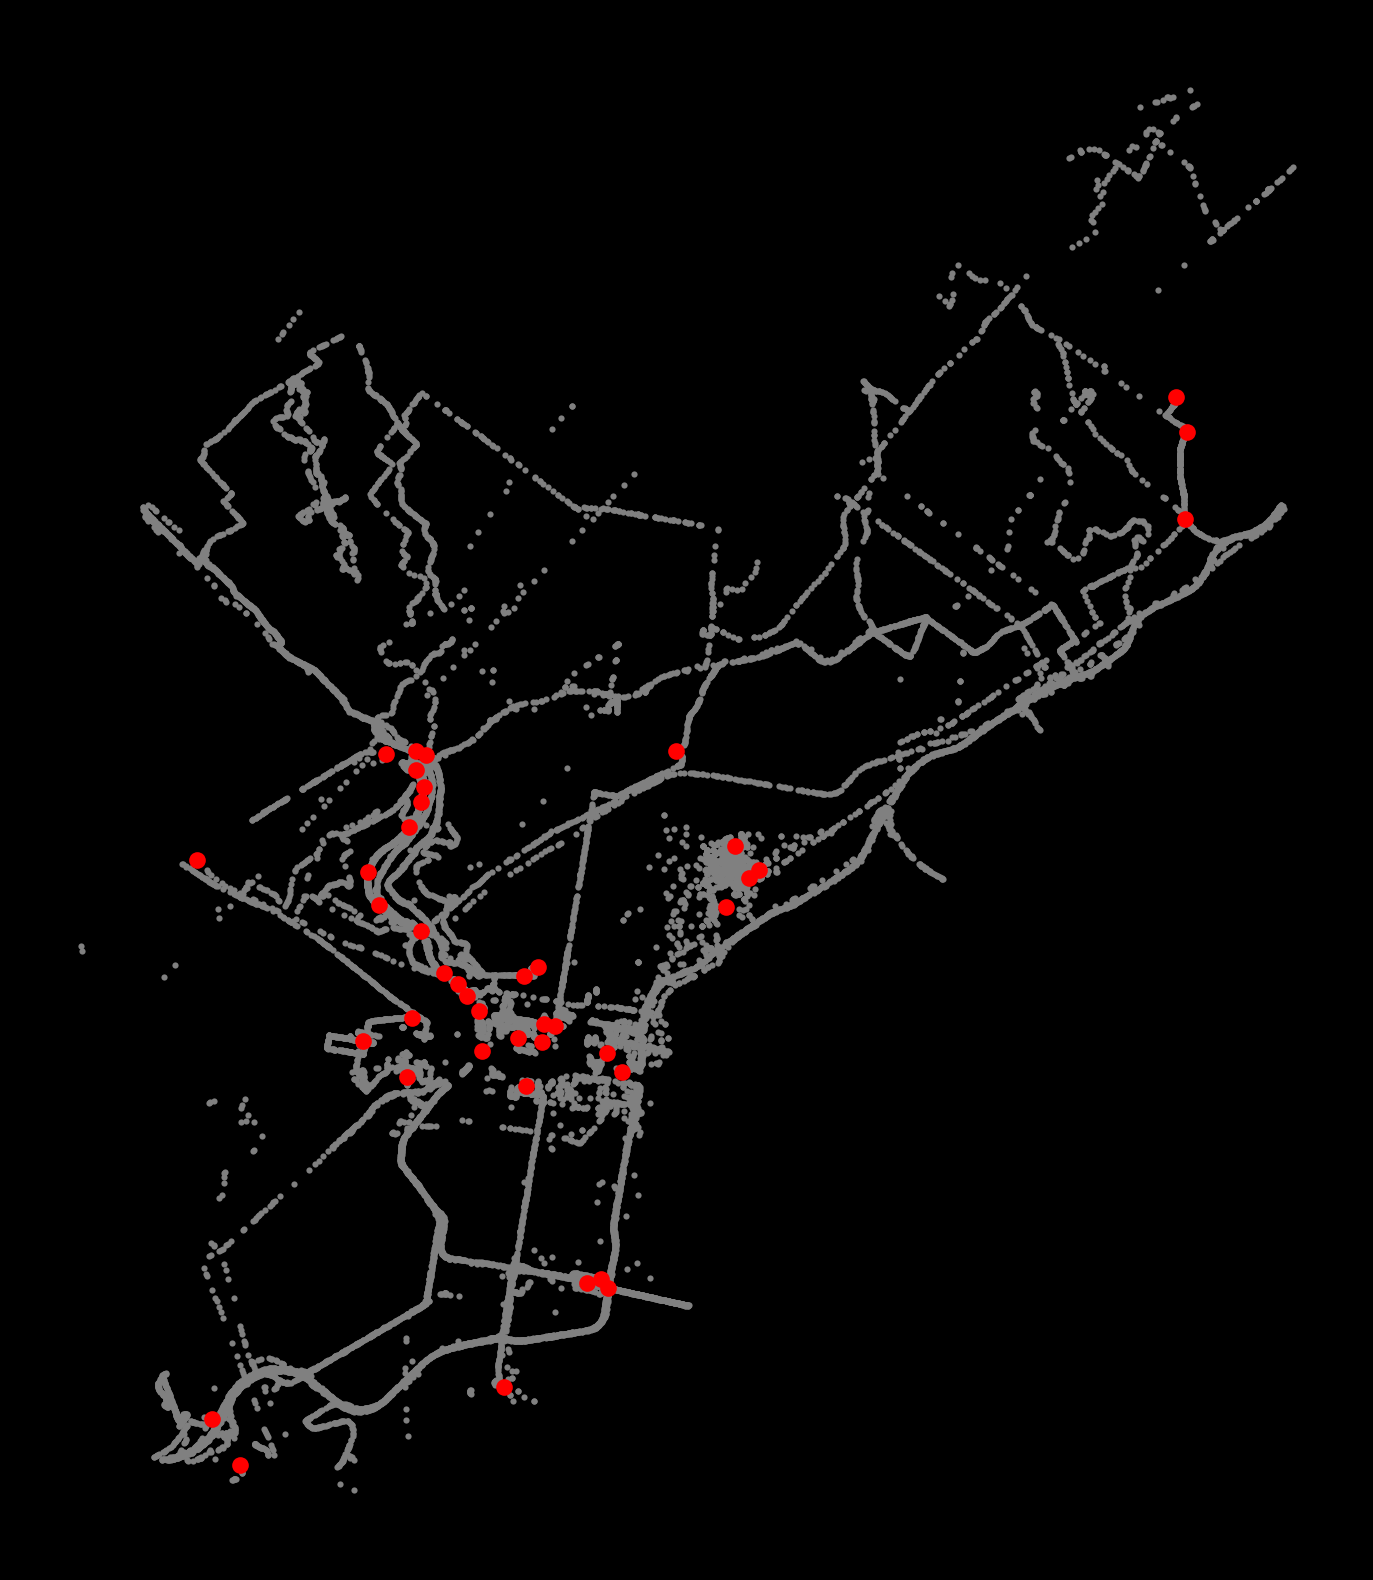

In [17]:
# Setup figure and axis
f, ax = plt.subplots(figsize=(10, 10), facecolor="black")

# Plot the noise samples in grey
noise = coords.loc[coords["label"] == -1]
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)

# Loop over each cluster number
for label_num in range(0, num_clusters):

    # Extract the samples with this label number
    this_cluster = coords.loc[coords["label"] == label_num]

    # Calculate the mean (x,y) point for this cluster in red
    x_mean = this_cluster["x"].mean()
    y_mean = this_cluster["y"].mean()
    
    # Plot this centroid point in red
    ax.scatter(x_mean, y_mean, linewidth=0, color="red")

# Format
ax.set_axis_off()
ax.set_aspect("equal")

## Extending DBSCAN beyond just spatial coordinates

DBSCAN can perform high-density clusters from more than just spatial coordinates, as long as they are properly normalized

## Exercise: Extracting patterns from NYC taxi rides

I've extracted data for taxi pickups or drop offs occurring in the Williamsburg neighborhood of NYC from the NYC taxi open data. 

Includes data for: 
- Pickup/dropoff location
- Fare amount
- Trip distance
- Pickup/dropoff hour

**Goal:** identify clusters of similar taxi rides that are not only clustered spatially, but also clustered for features like hour of day and trip distance

Inspired by [this CARTO blog post](https://carto.com/blog/using-location-data-identify-communities-williamsburg-ny/)

### Step 1: Load the data

See the `data/williamsburg_taxi_trips.csv` file in this week's repository.

In [18]:
taxi = pd.read_csv("./data/williamsburg_taxi_trips.csv")
taxi.head()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:41   2015-01-15 19:20:22                2           7.13   
1  2015-01-15 19:05:44   2015-01-15 19:17:44                1           2.92   
2  2015-01-25 00:13:06   2015-01-25 00:34:32                1           3.05   
3  2015-01-26 12:41:15   2015-01-26 12:59:22                1           8.10   
4  2015-01-20 22:49:11   2015-01-20 22:58:46                1           3.50   

    pickup_x   pickup_y  dropoff_x  dropoff_y  fare_amount  tip_amount  \
0 -8223667.0  4979065.0 -8232341.0  4970922.0         21.5        4.50   
1 -8237459.0  4971133.5 -8232725.0  4970482.5         12.5        2.70   
2 -8236711.5  4972170.5 -8232267.0  4970362.0         16.5        5.34   
3 -8222485.5  4978445.5 -8233442.5  4969903.5         24.5        5.05   
4 -8236294.5  4970916.5 -8231820.5  4971722.0         12.5        2.00   

   dropoff_hour  pickup_hour  
0            19           19  
1            19           19  
2             0            0  
3            12           12  
4            22           22

In [19]:
len(taxi)

223722

### Step 2: Extract and normalize several features

We will focus on the following columns:
- `pickup_x` and `pickup_y`
- `dropoff_x` and `dropoff_y`
- `trip_distance`
- `pickup_hour`

Use the `StandardScaler` to normalize these features.

In [20]:
feature_columns = [
    "pickup_x",
    "pickup_y",
    "dropoff_x",
    "dropoff_y",
    "trip_distance",
    "pickup_hour",
]
features = taxi[feature_columns].copy()

In [21]:
features.head()

pickup_x   pickup_y  dropoff_x  dropoff_y  trip_distance  pickup_hour
0 -8223667.0  4979065.0 -8232341.0  4970922.0           7.13           19
1 -8237459.0  4971133.5 -8232725.0  4970482.5           2.92           19
2 -8236711.5  4972170.5 -8232267.0  4970362.0           3.05            0
3 -8222485.5  4978445.5 -8233442.5  4969903.5           8.10           12
4 -8236294.5  4970916.5 -8231820.5  4971722.0           3.50           22

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
# Scale these features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features

array([[ 3.35254171e+00,  2.18196697e+00,  8.59345108e-02,
         1.89871932e-01, -2.58698769e-03,  8.16908067e-01],
       [-9.37728802e-01, -4.08167622e-01, -9.76176333e-02,
        -9.77141849e-03, -2.81690985e-03,  8.16908067e-01],
       [-7.05204353e-01, -6.95217705e-02,  1.21306539e-01,
        -6.45086739e-02, -2.80981012e-03, -1.32713022e+00],
       ...,
       [-1.32952083e+00, -1.14848599e+00, -3.37095821e-01,
        -1.09933782e-01, -2.76011198e-03,  7.04063946e-01],
       [-7.52953521e-01, -7.01094651e-01, -2.61571762e-01,
        -3.00037860e-01, -2.84530879e-03,  7.04063946e-01],
       [-3.97090015e-01, -1.71084059e-02, -1.11647543e+00,
         2.84810408e-01, -2.93269014e-03,  8.16908067e-01]])

In [24]:
scaled_features_df = pd.DataFrame(scaled_features, columns=feature_columns)

In [25]:
scaled_features_df.head()

pickup_x  pickup_y  dropoff_x  dropoff_y  trip_distance  pickup_hour
0  3.352542  2.181967   0.085935   0.189872      -0.002587     0.816908
1 -0.937729 -0.408168  -0.097618  -0.009771      -0.002817     0.816908
2 -0.705204 -0.069522   0.121307  -0.064509      -0.002810    -1.327130
3  3.720070  1.979661  -0.440583  -0.272783      -0.002534     0.026999
4 -0.575488 -0.479032   0.334734   0.553273      -0.002785     1.155440

In [26]:
scaled_features_df.mean()

pickup_x        -5.582694e-14
pickup_y        -5.503853e-14
dropoff_x       -1.949372e-13
dropoff_y        2.937845e-14
trip_distance    1.071903e-18
pickup_hour     -8.673676e-17
dtype: float64

In [27]:
scaled_features_df.std()

pickup_x         1.000002
pickup_y         1.000002
dropoff_x        1.000002
dropoff_y        1.000002
trip_distance    1.000002
pickup_hour      1.000002
dtype: float64

In [28]:
print(scaled_features.shape)
print(features.shape)

(223722, 6)
(223722, 6)


### Step 3: Run DBSCAN to extract high-density clusters

- We want the highest density clusters, ideally no more than about 30-50 clusters.
- Run the DBSCAN and experiment with different values of `eps` and `min_samples`
    - I started with `eps` of 0.25 and `min_samples` of 50 

- Add the labels to the original data frame and calculate the number of clusters. It should be less than 50 or so. 
    
**Hint:** If the algorithm is taking a long time to run (more than a few minutes), the `eps` is probably too big!

In [29]:
# Run DBSCAN 
cores, labels = dbscan(scaled_features, eps=0.25, min_samples=50)

# Add the labels back to the original (unscaled) dataset
features['label'] = labels

In [30]:
# Extract the number of clusters 
num_clusters = features['label'].nunique() - 1
print(num_clusters)

27


In [31]:
# Same thing!
features["label"].max() + 1

27

### Step 4: Identify the 5 largest clusters

Group by the label, calculate and sort the sizes to find the label numbers of the top 5 largest clusters

In [32]:
N = features.groupby('label').size()
print(N)

label
-1     101292
 0       4481
 1      50673
 2      33277
 3      24360
 4        912
 5       2215
 6       2270
 7       1459
 8        254
 9        519
 10       183
 11       414
 12       224
 13       211
 14       116
 15        70
 16        85
 17       143
 18        76
 19        69
 20        86
 21        49
 22        51
 23        97
 24        52
 25        41
 26        43
dtype: int64


In [33]:
# sort from largest to smallest
N = N.sort_values(ascending=False)

N

label
-1     101292
 1      50673
 2      33277
 3      24360
 0       4481
 6       2270
 5       2215
 7       1459
 4        912
 9        519
 11       414
 8        254
 12       224
 13       211
 10       183
 17       143
 14       116
 23        97
 20        86
 16        85
 18        76
 15        70
 19        69
 24        52
 22        51
 21        49
 26        43
 25        41
dtype: int64

In [34]:
# extract labels (ignoring label -1 for noise)
top5 = N.iloc[1:6]

top5

label
1    50673
2    33277
3    24360
0     4481
6     2270
dtype: int64

In [35]:
top5_labels = top5.index.tolist()

top5_labels

[1, 2, 3, 0, 6]

### Step 5: Get mean statistics for the top 5 largest clusters

To better identify trends in the top 5 clusters, calculate the mean trip distance and pickup_hour for each of the clusters.

In [36]:
# get the features for the top 5 labels
selection = features['label'].isin(top5_labels)

# select top 5 and groupby by the label
grps = features.loc[selection].groupby('label')

# calculate average pickup hour and trip distance per cluster
avg_values = grps[['pickup_hour', 'trip_distance']].mean()

avg_values

pickup_hour  trip_distance
label                            
0        18.599643       7.508730
1        20.127405       4.025859
2         1.699943       3.915581
3         9.536905       1.175154
6         1.494714       2.620546

### Step 6a: Visualize the top 5 largest clusters

Now visualize the top 5 largest clusters:
- plot the dropoffs and pickups (same color) for the 5 largest clusters
- include the "noise" samples, shown in gray
      

**Hints:**
- For a given cluster, plot the dropoffs and pickups with the same color so we can visualize patterns in the taxi trips
- A good color scheme for a black background is given below

In [37]:
# a good color scheme for a black background
colors = ['aqua', 'lime', 'red', 'fuchsia', 'yellow']

In [38]:
# EXAMPLE: enumerating a list
for i, label_num in enumerate([0, 1, 2, 3, 4]):
    print(f"i = {i}")
    print(f"label_num = {label_num}")

i = 0
label_num = 0
i = 1
label_num = 1
i = 2
label_num = 2
i = 3
label_num = 3
i = 4
label_num = 4


Plotting cluster #1...
Plotting cluster #2...
Plotting cluster #3...
Plotting cluster #0...
Plotting cluster #6...


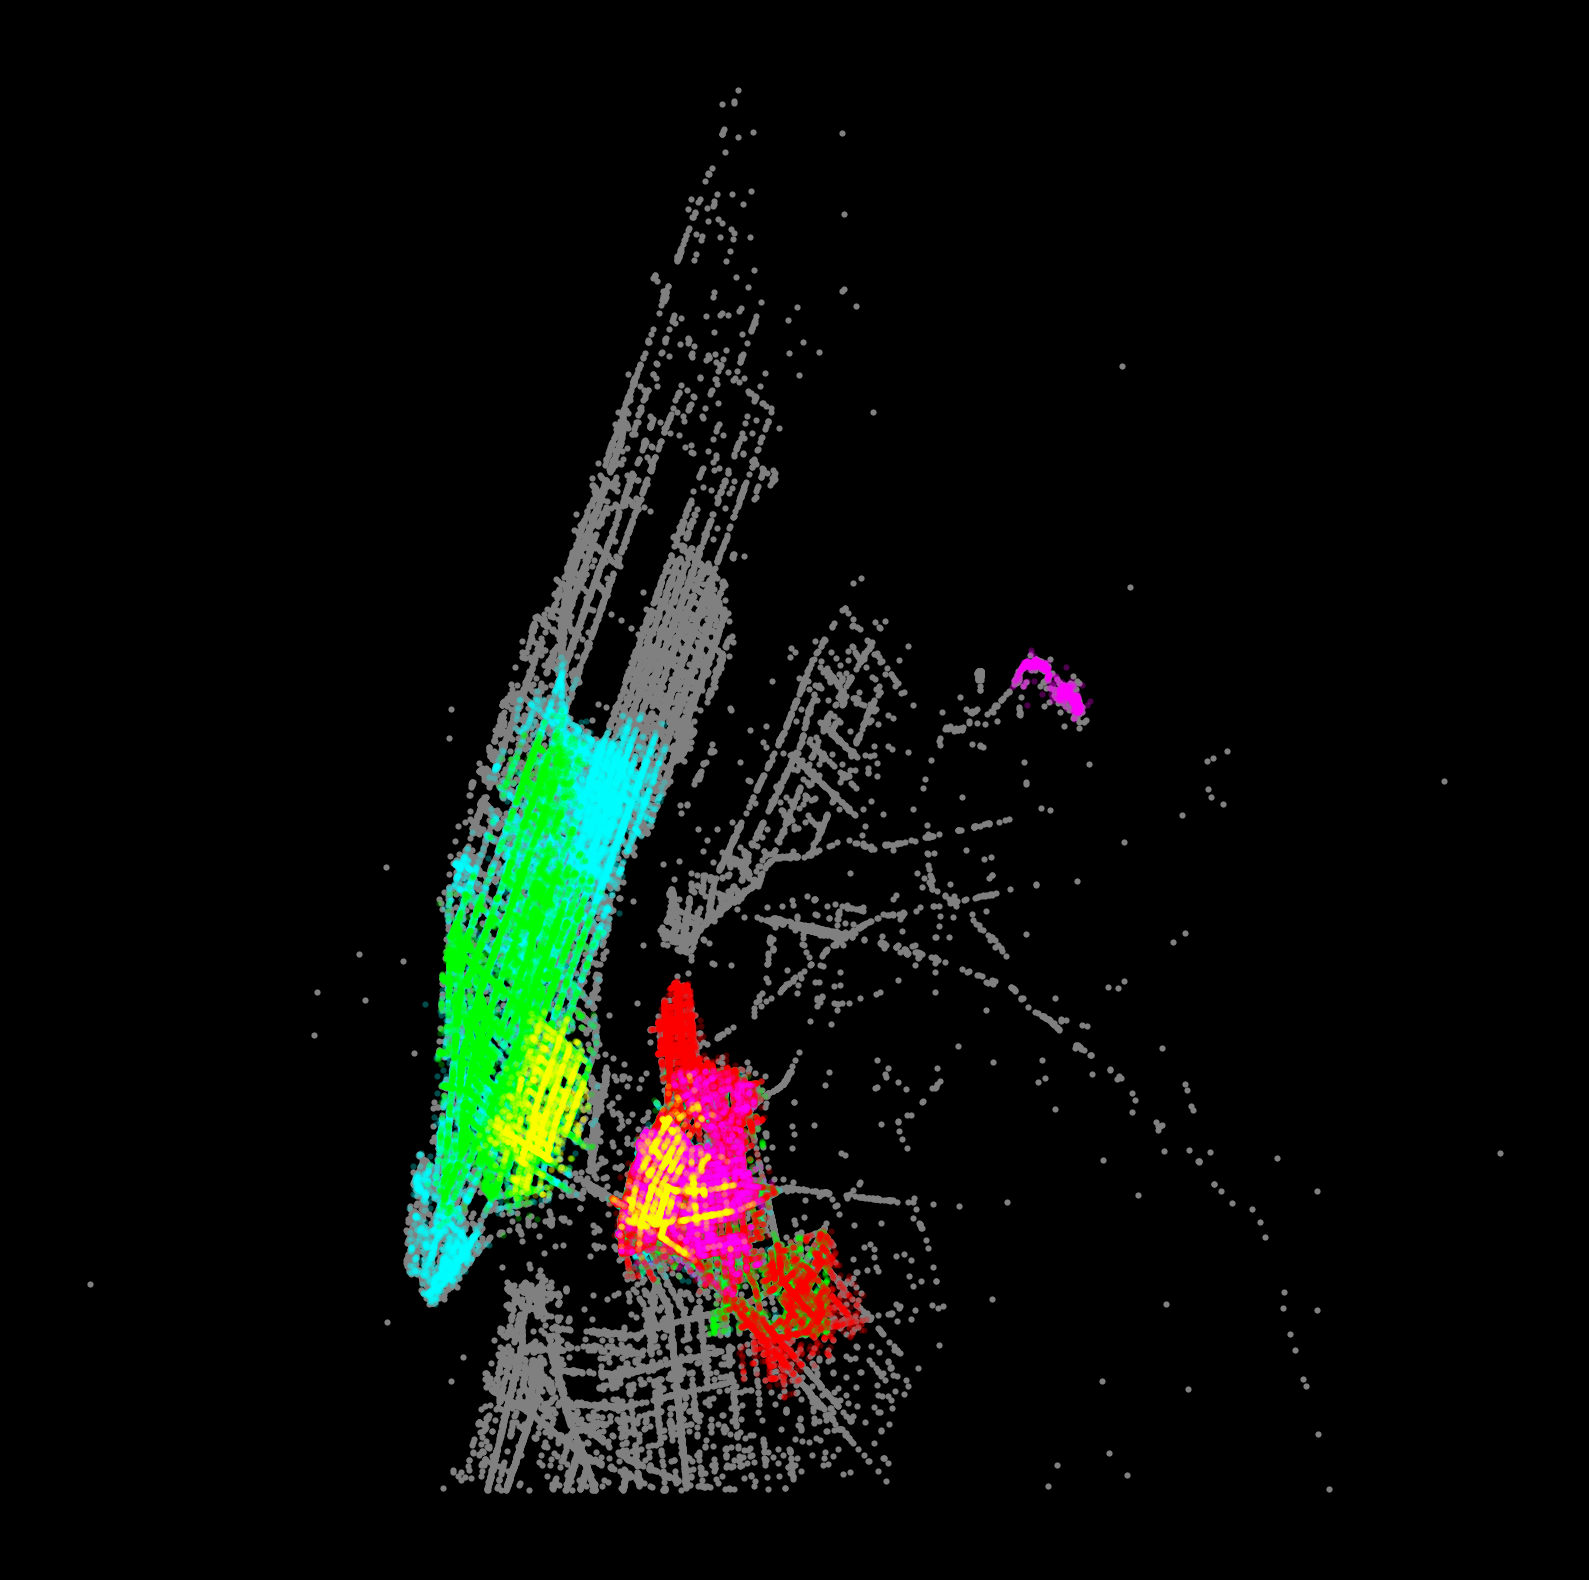

In [39]:
# Setup figure and axis
f, ax = plt.subplots(figsize=(10, 10), facecolor="black")

# Plot noise in grey
noise = features.loc[features["label"] == -1]
ax.scatter(noise["pickup_x"], noise["pickup_y"], c="grey", s=5, linewidth=0)

# specify colors for each of the top 5 clusters
colors = ["aqua", "lime", "red", "fuchsia", "yellow"]

# loop over top 5 largest clusters
for i, label_num in enumerate(top5_labels):
    print(f"Plotting cluster #{label_num}...")

    # select all the samples with label equals "label_num"
    this_cluster = features.loc[features["label"] == label_num]

    # plot pickups
    ax.scatter(
        this_cluster["pickup_x"],
        this_cluster["pickup_y"],
        linewidth=0,
        color=colors[i],
        s=5,
        alpha=0.3,
    )

    # plot dropoffs
    ax.scatter(
        this_cluster["dropoff_x"],
        this_cluster["dropoff_y"],
        linewidth=0,
        color=colors[i],
        s=5,
        alpha=0.3,
    )

# Display the figure
ax.set_axis_off()

## If you're feeling ambitious, and time-permitting...

### Step 6b: Visualizing one cluster at a time

Another good way to visualize the results is to explore the other clusters one at a time, plotting both the pickups and dropoffs to identify the trends.  

Use different colors for pickups/dropoffs to easily identify them.

Make it a function so we can repeat it easily:

In [40]:
def plot_taxi_cluster(label_num):
    """
    Plot the pickups and dropoffs for the input cluster label
    """
    # Setup figure and axis
    f, ax = plt.subplots(figsize=(10, 10), facecolor='black')

    # Plot noise in grey
    noise = features.loc[features['label']==-1]
    ax.scatter(noise['pickup_x'], noise['pickup_y'], c='grey', s=5, linewidth=0)

    # get this cluster
    this_cluster = features.loc[features['label']==label_num]

    # Plot pickups in fuchsia
    ax.scatter(this_cluster['pickup_x'], this_cluster['pickup_y'], 
               linewidth=0, color='fuchsia', s=5, alpha=0.3)

    # Plot dropoffs in aqua
    ax.scatter(this_cluster['dropoff_x'], this_cluster['dropoff_y'], 
               linewidth=0, color='aqua', s=5, alpha=0.3)

    # Display the figure
    ax.set_axis_off()
    plt.show()

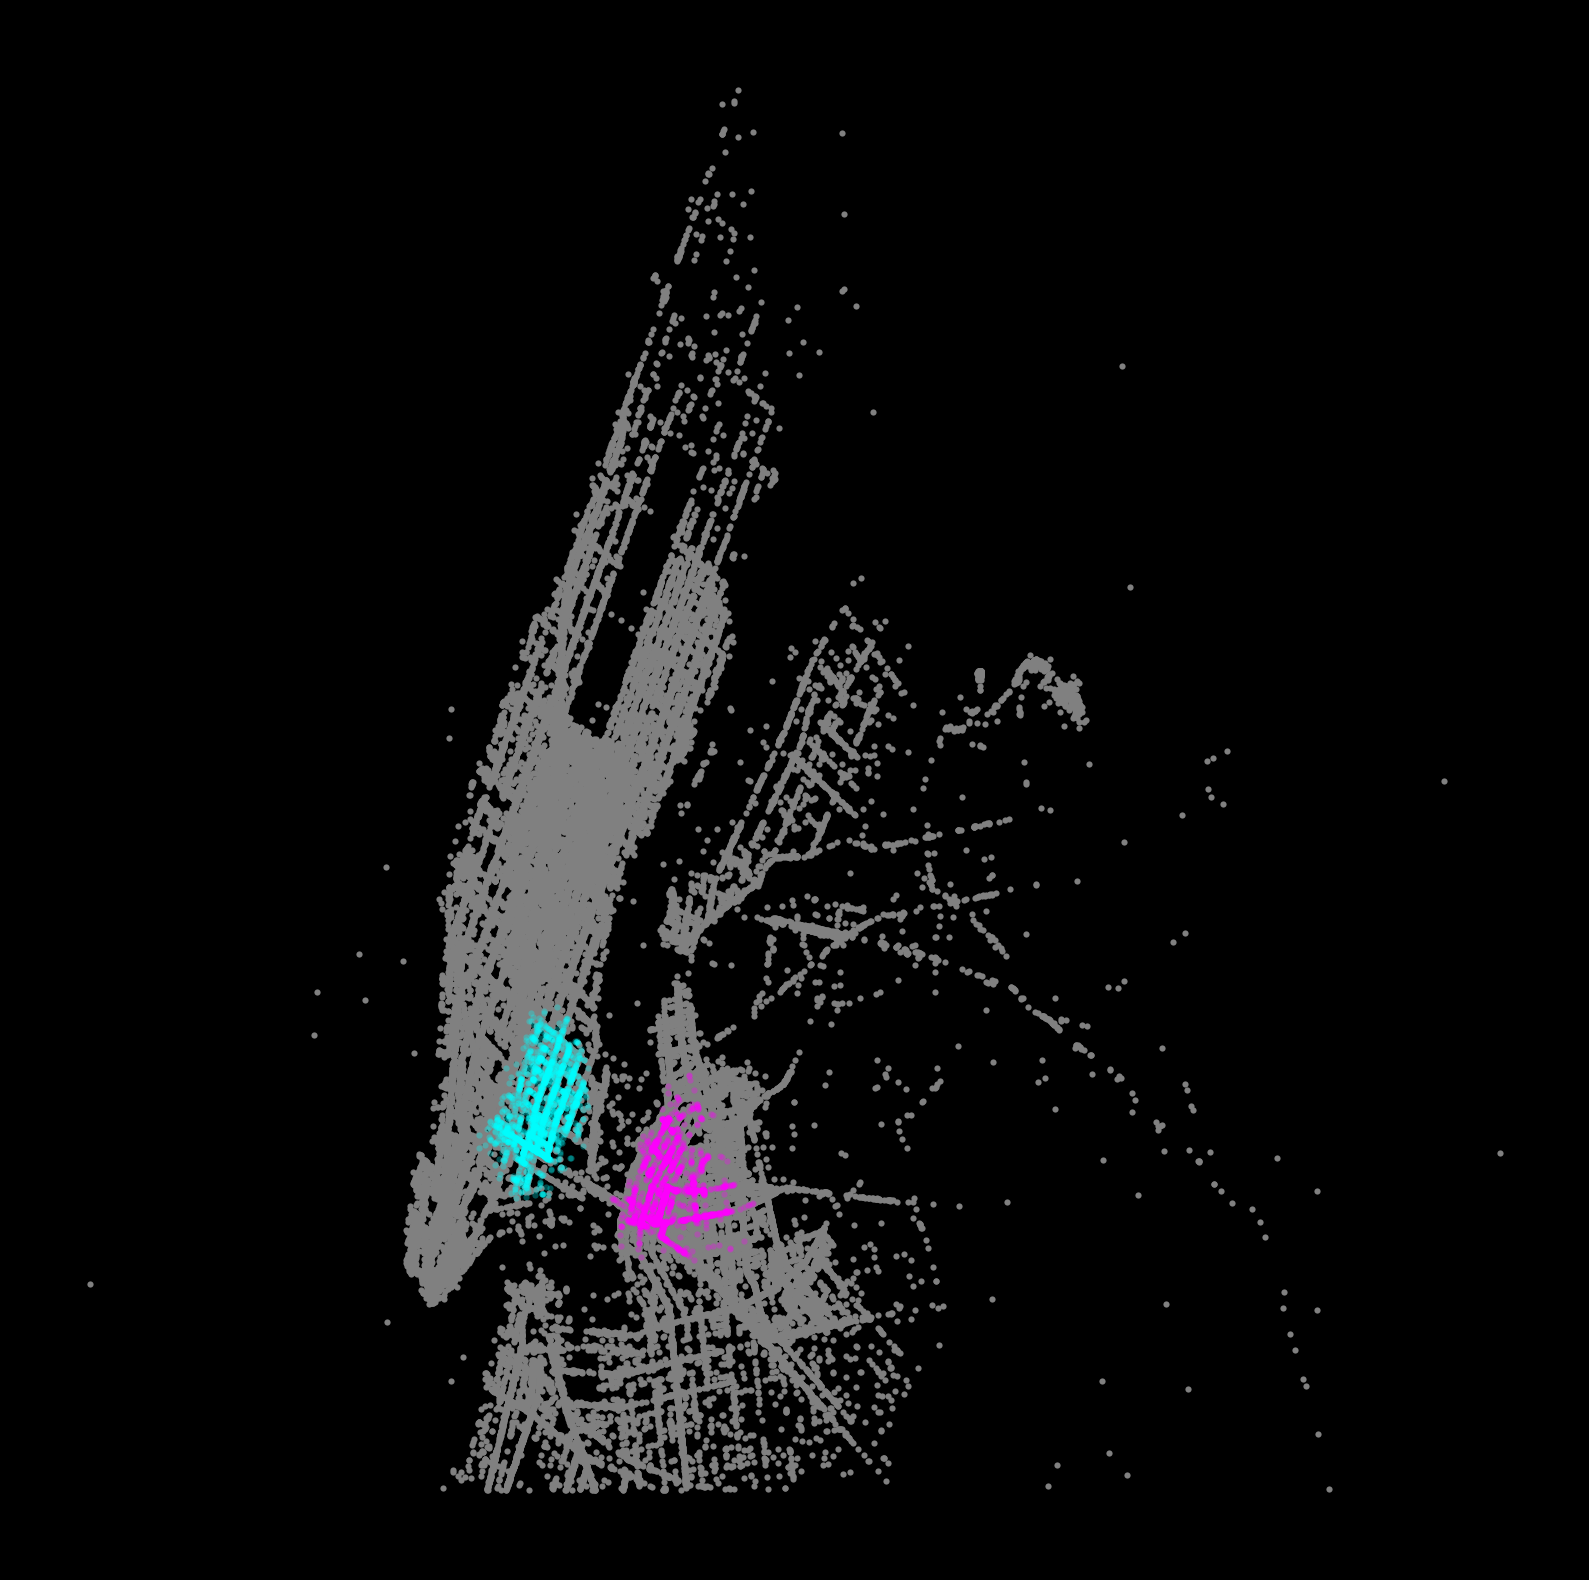

In [41]:
# plot specific label
plot_taxi_cluster(label_num=6)

### Step 7: an interactive map of clusters with hvplot + datashader

- We'll plot the pickup/dropoff locations for the top 5 clusters
- Use the `.hvplot.scatter()` function to plot the x/y points
- Specify the `c=` keyword as the column holding the cluster label
- Specify the aggregator as `ds.count_cat("label")` — this will color the data points using our categorical color map
- Use the `datashade=True` keyword to tell hvplot to use datashader
- Add a background tile using Geoviews
- Combine the pickups, dropoffs, and background tile into a single interactive map


In [42]:
# map colors to the top 5 cluster labels
color_key = dict(zip(top5_labels, ['aqua', 'lime', 'red', 'fuchsia', 'yellow']))
print(color_key)

{1: 'aqua', 2: 'lime', 3: 'red', 0: 'fuchsia', 6: 'yellow'}


In [43]:
# extract the features for the top 5 clusters
top5_features = features.loc[features['label'].isin(top5_labels)]

In [44]:
import hvplot.pandas
import datashader as ds
import geoviews as gv

In [45]:
# Pickups using a categorical color map
pickups = top5_features.hvplot.scatter(
    x="pickup_x",
    y="pickup_y",
    c="label",
    aggregator=ds.count_cat("label"),
    datashade=True,
    cmap=color_key,
    width=800,
    height=600,
)

# Dropoffs using a categorical color map
dropoffs = top5_features.hvplot.scatter(
    x="dropoff_x",
    y="dropoff_y",
    c="label",
    aggregator=ds.count_cat("label"),
    datashade=True,
    cmap=color_key,
    width=800,
    height=600,
)


pickups * dropoffs * gv.tile_sources.CartoDark

/Users/nhand/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/holoviews/operation/datashader.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category] = df[category].astype('category')


:DynamicMap   []
   :Overlay
      .RGB.I  :RGB   [pickup_x,pickup_y]   (R,G,B,A)
      .RGB.II :RGB   [dropoff_x,dropoff_y]   (R,G,B,A)
      .WMTS.I :WMTS   [Longitude,Latitude]

## That's it! 

Next time, regressions with scikit-learn!